<a href="https://colab.research.google.com/github/sedatoner/wine-knn-classifier/blob/main/Wine_Classification_with_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Dataset Metadata 
{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)9014

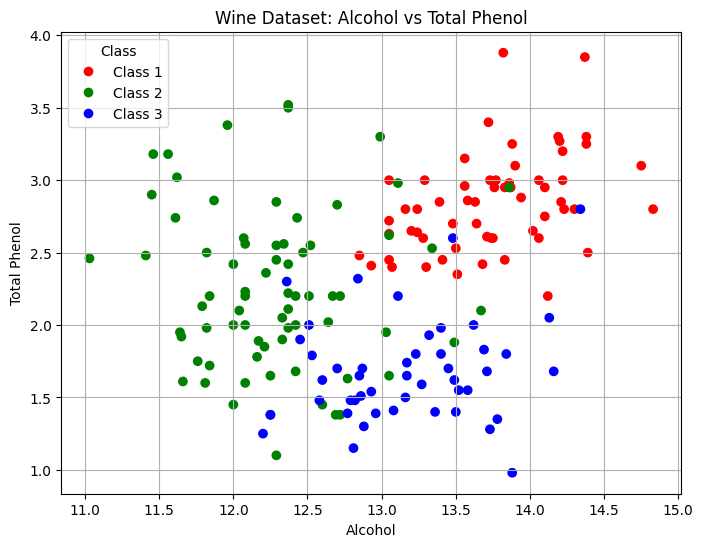


Missing values in each feature:
 Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64


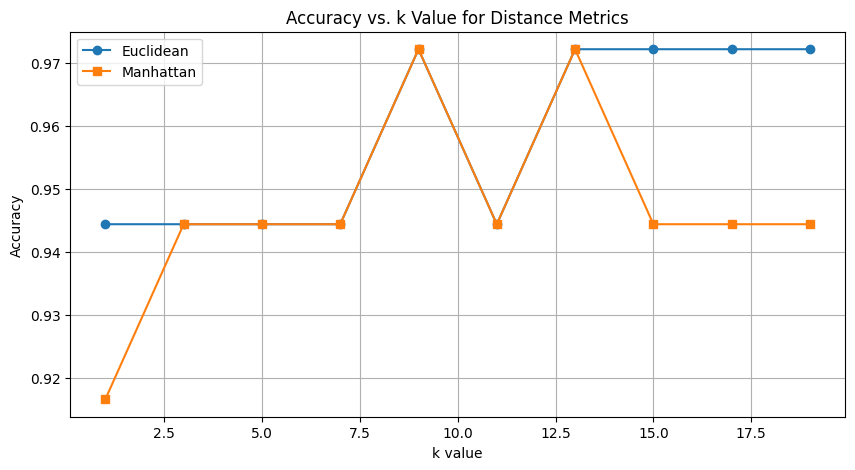


--- Final Evaluation with k=3 ---
Confusion Matrix:
 [[14  0  0]
 [ 1 12  1]
 [ 0  0  8]]

Classification Report:
               precision    recall  f1-score   support

           1       0.93      1.00      0.97        14
           2       1.00      0.86      0.92        14
           3       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



In [2]:
!pip install ucimlrepo  # veri setini çekmek için lazım

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

wine = fetch_ucirepo(id=109)  # wine dataset'i direkt çekiyorum
X = wine.data.features
y = wine.data.targets

print("\n Dataset Metadata ")
print(wine.metadata)

print("\n Feature Preview ")
print(X.head())
print("\n Target Preview ")
print(y.head())

# scatter – iki feature'ı görselleştireyim
plt.figure(figsize=(8, 6))
colors = {1: 'red', 2: 'green', 3: 'blue'}
plt.scatter(X['Alcohol'], X['Total_phenols'], c=y['class'].map(colors))
plt.xlabel('Alcohol')
plt.ylabel('Total Phenol')
plt.title('Wine Dataset: Alcohol vs Total Phenol')
plt.grid(True)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=f'Class {i}',
               markerfacecolor=c, markersize=8) for i, c in colors.items()], title='Class')
plt.show()

# eksik veri var mı bakıyorum
print("\nMissing values in each feature:\n", X.isnull().sum())

# scale etmeden olmaz, çünkü mesafe hesabı yapılacak
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# veriyi ayır – test için %20 yeter
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# mesafe fonksiyonları – ikisini de deneyeceğim
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

# kendi knn sınıfım – hazır olanları kullanmayacağım
class KNN:
    def __init__(self, k=3, distance_metric=euclidean_distance):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.reset_index(drop=True)

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [self.distance_metric(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train.iloc[i].values[0] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# k'ya göre accuracy'ye bakacağım
ks = list(range(1, 20, 2))
accuracies_euclidean = []
accuracies_manhattan = []

for k in ks:
    knn = KNN(k=k, distance_metric=euclidean_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_euclidean.append(accuracy_score(y_test, y_pred))

    knn = KNN(k=k, distance_metric=manhattan_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_manhattan.append(accuracy_score(y_test, y_pred))

# görsel kıyas – hangi k daha iyi vs
plt.figure(figsize=(10, 5))
plt.plot(ks, accuracies_euclidean, label='Euclidean', marker='o')
plt.plot(ks, accuracies_manhattan, label='Manhattan', marker='s')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k Value for Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()

# en iyi k=3 gibi duruyor, onunla test yapayım
best_k = 3
final_knn = KNN(k=best_k, distance_metric=euclidean_distance)
final_knn.fit(X_train, y_train)
y_pred = final_knn.predict(X_test)

print(f"\n--- Final Evaluation with k={best_k} ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
